# Data analysis - `keras`

In [ ]:
import os
import numpy as np
import pickle
import nibabel as nb
import pandas as pd
from scipy.stats import zscore
from keras import layers, models, optimizers, regularizers
from random import shuffle

Using TensorFlow backend.


# Create dataset

In [ ]:
def read_dataset(filename, outlier_thr=5):

    # Read csv file
    df = pd.read_csv(filename)

    # extract relevant variables
    sub_id = np.array(df['PAC_ID'])
    label = np.array(df['Label'] - 1)
    df = df.drop(['PAC_ID', 'Label'], 1)
    header = df.keys()
    
    # Clean dataset - drop subjects with values above `outlier_thr` STD
    outliers = np.sum((np.abs(zscore(df)) > outlier_thr), 1) != 0
    print('%d outliers detected.' % outliers.sum())
    data = np.array(df.drop(np.where(outliers)[0]))
    sub_id = sub_id[np.invert(outliers)]
    label = label[np.invert(outliers)]
    
    # zscore data
    data = zscore(data)

    # Reset Gender and Scanner values to nominal values
    data[:,1] = (data[:,1]>0) + 1
    data[:,3] = [np.where(i==np.unique(data[:,3]))[0][0] + 1for i in data[:,3]]

    return pd.DataFrame(data, columns=header), sub_id, label

In [ ]:
data, sub_id, label = read_dataset('data/PAC2018_Covariates_detailed.csv', outlier_thr=5)
data.head()

8 outliers detected.


,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,Left_Frontal_Pole,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1.610405,1.0,1.479924,2.0,-0.890455,1.091014,1.080367,1.034026,0.060878,1.096927,...,1.093750,1.094903,1.037705,-0.896948,-0.255150,-0.724690,-0.269052,1.791264,1.591691,0.091529
1,-1.146076,1.0,-0.052883,1.0,1.134709,-0.118805,-0.147065,0.290905,0.904814,0.017488,...,-0.060199,-0.013714,0.079673,0.634875,1.097503,0.176912,-0.143525,0.223282,0.283818,-0.110870
2,-0.200997,2.0,-0.322187,2.0,-0.910314,0.213228,0.466651,-0.390523,0.488056,-0.281768,...,0.167886,0.162364,0.443724,0.107536,-0.337023,-0.458773,-0.199329,0.879846,0.603997,0.182364
3,-0.200997,1.0,1.526994,3.0,-0.888128,1.178024,1.141739,1.173458,0.863138,0.754654,...,1.022908,1.000870,2.157792,1.573471,2.835140,1.080137,0.815276,0.185643,0.730864,2.010200
4,2.004188,2.0,-0.934370,1.0,1.027570,-2.074238,-2.049584,-2.070608,-0.824733,-2.118870,...,-2.148225,-2.165083,-1.193547,-1.593558,-2.270355,-1.290505,-1.337832,-1.919742,-2.127827,-1.856324


# Create 2D Mosaic of brains

In [ ]:
create_h5 = False

import h5py
from glob import glob
fileList = glob('data/nifti/*.nii.gz')

if create_h5:
    for i, f in enumerate(fileList):

        # Get data for each subject
        img = nb.load(f).get_fdata()
        img = img[15:105, 15:125, 15:100]
        
        # Create frontal mosaic
        front = np.rollaxis(img, 0).reshape((img.shape[0], -1))
        with h5py.File(f.replace('.nii.gz', '_front.h5'), 'w') as h5f:
            h5f.create_dataset('dataset', data=front)
        
        # Create sagital mosaic
        side = np.rollaxis(img, 1).reshape((img.shape[1], -1))
        with h5py.File(f.replace('.nii.gz', '_side.h5'), 'w') as h5f:
            h5f.create_dataset('dataset', data=side)

        # Create dorsal mosaic
        top = np.rollaxis(img, 2, 1).reshape((img.shape[0], -1))
        with h5py.File(f.replace('.nii.gz', '_top.h5'), 'w') as h5f:
            h5f.create_dataset('dataset', data=top)

# Create dataset (select dataset, balance it and divide train and validation)

In [ ]:
def balance_dataset(sub_id, labels, data):
    max_label_size = np.min([np.sum(lab == labels) 
                             for lab in np.unique(labels)])

    labels_1 = np.where(labels == 0)[0]
    np.random.shuffle(labels_1)
    labels_1 = labels_1[:max_label_size]

    labels_2 = np.where(labels == 1)[0]
    np.random.shuffle(labels_2)
    labels_2 = labels_2[:max_label_size]

    new_data_id = np.hstack((labels_1, labels_2))
    np.random.shuffle(new_data_id)
    labels = labels[new_data_id]
    sub_id = sub_id[new_data_id]
    data = data[new_data_id]

    return (sub_id, labels, data)

In [ ]:
def get_train_valid_set(sub_id, label, data, group='123', train_ratio=0.8):
    
    selecter = [str(int(d)) in group for d in data.Scanner]

    group_sub, group_label, group_data = balance_dataset(
        sub_id[selecter], label[selecter], np.array(data[selecter]))
    
    
    train_size = int(len(group_sub) * train_ratio)
    valid_size = len(group_sub) - train_size

    counter1 = 0
    counter2 = 0
    train_list = []

    for i, s in enumerate(group_sub):
        if counter1 < (train_size / 2) and group_label[i] == 0:
            train_list.append(s)
            counter1 += 1
        elif counter2 < (train_size / 2) and group_label[i] == 1:
            train_list.append(s)
            counter2 += 1

    selecter = np.array([True if e in train_list else False for i, e in enumerate(group_sub)])

    train_list = group_sub[selecter]
    valid_list = group_sub[np.invert(selecter)]
    
    return train_list, valid_list, group_sub, group_label, group_data

# `Keras` model

In [ ]:
def data_gen(fileList, batch, view):

    while True:
        for r in range(0, len(fileList), batch):

            batch_data = []
            batch_label = []

            for i in range(batch):
                if r + i >= len(fileList):
                    break
                else:

                    patientID = fileList[r]
                    f = 'data/nifti/%s.nii.gz' % patientID

                    # Get data for each subject
                    with h5py.File(f.replace('.nii.gz', '_%s.h5' % view),'r') as h5f:
                        img = h5f['dataset'][:]
                    batch_data.append(img)

                    # Get data for each label
                    labelID = group_label[group_sub == patientID]
                    batch_label.append(labelID)

            yield (np.array(batch_data)[..., None], np.array(batch_label))

In [ ]:
# Neural network definition
model = models.Sequential()

top_shape = (90, 9350, 1)
side_shape = (90, 7650, 1)
front_shape = (90, 9350, 1)
model.add(layers.Conv2D(32, (3, 10), padding='same', activation='relu', strides=(2, 5), name='input',
                        input_shape=front_shape, batch_size=None))
model.add(layers.MaxPooling2D((2, 5)))

model.add(layers.Conv2D(32, (3, 6), activation='relu'))
model.add(layers.MaxPooling2D((2, 4)))

model.add(layers.Conv2D(32, (3, 6), activation='relu'))
model.add(layers.MaxPooling2D((2, 4)))

model.add(layers.Conv2D(32, (3, 6), activation='relu'))
model.add(layers.MaxPooling2D((2, 4)))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu', name='hidden-0'))
model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 45, 1870, 32)      992       
_________________________________________________________________
max_pooling2d_236 (MaxPoolin (None, 22, 374, 32)       0         
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 20, 369, 32)       18464     
_________________________________________________________________
max_pooling2d_237 (MaxPoolin (None, 10, 92, 32)        0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 8, 87, 32)         18464     
_________________________________________________________________
max_pooling2d_238 (MaxPoolin (None, 4, 21, 32)         0         
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 2, 16, 32)         18464     
__________

In [ ]:
# Batch size
batch_size = 5

# Training to Validation set ratio
train_ratio=0.8

In [ ]:
# Create Groups
group_id = '23'
train_list, valid_list, group_sub, group_label, group_data = get_train_valid_set(
    sub_id, label, data, group=group_id, train_ratio=0.8)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
view = 'front'

history = model.fit_generator(
    data_gen(train_list, batch_size, view),
    steps_per_epoch=int(np.ceil(len(train_list) / batch_size)),
    validation_data=data_gen(valid_list, batch_size, view),
    validation_steps=int(np.ceil(len(valid_list) / batch_size)),
    epochs=100, shuffle=True)

Epoch 1/100
142/142 [==============================] - 46s 321ms/step - loss: 0.6961 - binary_accuracy: 0.4366 - val_loss: 0.7015 - val_binary_accuracy: 0.4213
Epoch 2/100
142/142 [==============================] - 46s 322ms/step - loss: 0.6947 - binary_accuracy: 0.5070 - val_loss: 0.7015 - val_binary_accuracy: 0.4213
Epoch 3/100
142/142 [==============================] - 45s 314ms/step - loss: 0.6931 - binary_accuracy: 0.5282 - val_loss: 0.7039 - val_binary_accuracy: 0.4213
Epoch 4/100
142/142 [==============================] - 44s 311ms/step - loss: 0.6921 - binary_accuracy: 0.5282 - val_loss: 0.7047 - val_binary_accuracy: 0.4213
Epoch 5/100
142/142 [==============================] - 45s 315ms/step - loss: 0.6908 - binary_accuracy: 0.5563 - val_loss: 0.7053 - val_binary_accuracy: 0.4213
Epoch 6/100
142/142 [==============================] - 44s 309ms/step - loss: 0.6894 - binary_accuracy: 0.5563 - val_loss: 0.7062 - val_binary_accuracy: 0.4213
Epoch 7/100
142/142 [===================

Epoch 52/100
142/142 [==============================] - 43s 300ms/step - loss: 0.0063 - binary_accuracy: 1.0000 - val_loss: 1.1593 - val_binary_accuracy: 0.4775
Epoch 53/100
142/142 [==============================] - 43s 301ms/step - loss: 0.0039 - binary_accuracy: 1.0000 - val_loss: 1.2599 - val_binary_accuracy: 0.4775
Epoch 54/100
142/142 [==============================] - 43s 301ms/step - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 1.3217 - val_binary_accuracy: 0.5056
Epoch 55/100
142/142 [==============================] - 43s 300ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 1.3942 - val_binary_accuracy: 0.5056
Epoch 56/100
142/142 [==============================] - 43s 300ms/step - loss: 7.7153e-04 - binary_accuracy: 1.0000 - val_loss: 1.4300 - val_binary_accuracy: 0.5056
Epoch 57/100
142/142 [==============================] - 43s 300ms/step - loss: 4.1475e-04 - binary_accuracy: 1.0000 - val_loss: 1.4675 - val_binary_accuracy: 0.5056
Epoch 58/100
142/142 [====

# Visualize results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

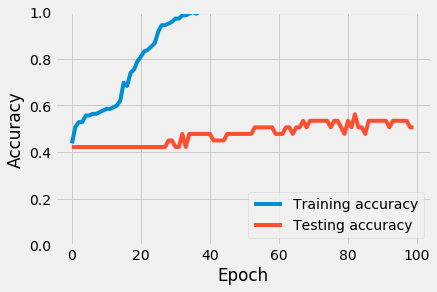

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)

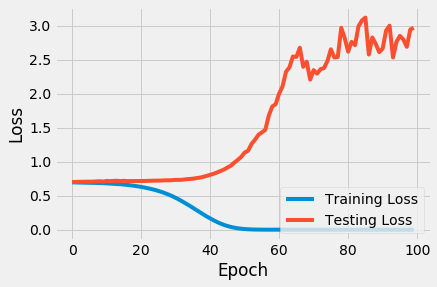

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=4)